In [88]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import color
from skimage import io
from scipy.ndimage import convolve, generate_binary_structure
import numba
from numba import jit
import time

The heat equation $$\alpha \nabla^2 u = \frac{\partial u}{ \partial t}$$

* $u$ is temperature
* $\alpha$ is the thermal diffusivity
* $t$ is time

in two dimensions and in discrete form, can be written as

$$\alpha \left( \frac{u_{i+1,j}^{(m)} -2u_{i,j}^{(m)} + u_{i-1,j}^{(m)}}{\Delta x^2} + \frac{u_{i,j+1}^{(m)} -2u_{i,j}^{(m)} + u_{i,j-1}^{(m)}}{\Delta y^2}\right) = \frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} $$ 

Can rearrange to solve for $m+1$ 

$$ u_j^{(m+1)} = u_j^{(m)} + \alpha \frac{\Delta t}{\Delta x^2} \left( u_{i+1,j}^{(m)} + u_{i-1,j}^{(m)} +  u_{i,j+1}^{(m)} + u_{i,j-1}^{(m)}  -4u_{i,j}^{(m)} \right) $$

In [89]:
edge = np.linspace(0, 1, 100)
xv, yv = np.meshgrid(edge, edge)

Load image. Find locations of the turkey pixels in boolean 2d array

In [90]:
img = color.rgb2gray(io.imread('../../output/turkey.png'))
img = np.flip(img, axis=0)
is_turkey = img<0.9

<ipython-input-90-04ae653af5fc>:1: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = color.rgb2gray(io.imread('../../output/turkey.png'))


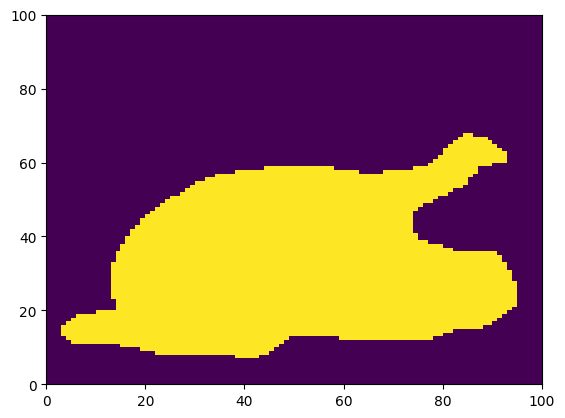

In [91]:
plt.pcolormesh(is_turkey)
plt.show()

Thermal diffusivity of the turkey:

In [92]:
a_turk = 1.32e-7

Oven and initial turkey temperature

In [93]:
rawturk_temp = 273.15 + 25
oven_temp = 273.15 + 165

Set the turkey to the initial turkey temperature and the oven to the preheated oven temperature

In [94]:
T0 = np.ones([100,100]) * oven_temp
T0[is_turkey] = rawturk_temp

Set the dimensions of the problem

In [95]:
x = 0.5
dx = 0.5/100
dt = 1

Compute $s = \alpha \Delta t / \Delta x^2$. $s$ needs to be much less than 1/4 for this to work.

In [96]:
s = a_turk * dt / dx**2
s

0.005279999999999999

In [97]:
kern = generate_binary_structure(2,1).astype(float)
kern[1,1] = -4
kern

array([[ 0.,  1.,  0.],
       [ 1., -4.,  1.],
       [ 0.,  1.,  0.]])

In [105]:
def solve_heat_pythonic(T0, is_turkey, N_times):
    T_curr = T0
    for t in range(1, N_times):
        T_curr = T_curr + s * convolve(T_curr, kern)
        T_curr[~is_turkey] = oven_temp
    return T_curr

In [117]:
t1 = time.perf_counter()
solve_heat_pythonic(T0, is_turkey, 1000)
t2 = time.perf_counter()
print(t2-t1)

0.1263969999999972


In [115]:
@numba.jit("f8[:,:](f8[:,:], b1[:,:], i8)", nopython=True, nogil=True)
def solve_heat_numba(T0, is_turkey, N_times):
    x_length, y_length = T0.shape
    T_curr = T0
    for t in range(1,N_times):
        for i in range(1, x_length-1):
            for j in range(1, y_length-1):
                if is_turkey[j][i]:
                    T_curr[j][i] = T_curr[j][i] + s * (T_curr[j+1][i] + T_curr[j-1][i] +\
                                                    T_curr[j][i+1] + T_curr[j][i-1] -\
                                                    4*T_curr[j][i])          
    return T_curr

In [116]:
t1 = time.perf_counter()
solve_heat_numba(T0, is_turkey, 1000)
t2 = time.perf_counter()
print(t2-t1)

0.03652269999975033


Convert to celcius

In [76]:
heat_frames -= 273.15

Make heat plot of final snapshot

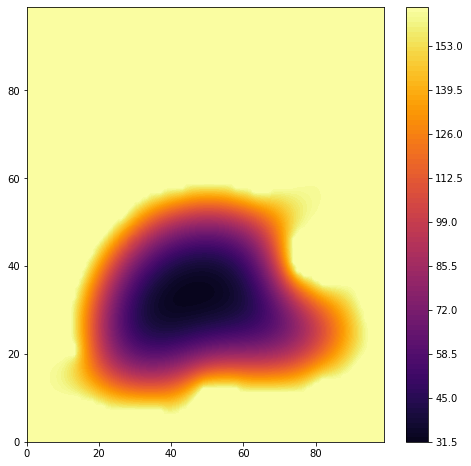

In [47]:
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
a = plt.contourf(heat_frames[1000], 100, cmap=my_cmap, vmin=rawturk_temp-273.15, vmax=oven_temp-273.15)
plt.colorbar(a)

Make animation

In [1]:
def animate(i):
    ax.clear()
    ax.contourf(heat_frames[10*i], 100, cmap=my_cmap, vmin=rawturk_temp-273.15, vmax = oven_temp-273.15)

    return fig,

fig, ax = plt.subplots(figsize=(8,6))
ani = animation.FuncAnimation(fig, animate,
                               frames=359, interval=50)
ani.save('cooked.gif',writer='pillow',fps=30)

SyntaxError: invalid syntax (<ipython-input-1-bfe69c3dddc4>, line 1)

Examine a few quantities

In [77]:
t = np.linspace(0, 10, len(heat_frames))

In [78]:
avg_temp = np.array([heat_frame[turkey_bool].mean() for heat_frame in heat_frames]) 
min_temp = np.array([heat_frame[turkey_bool].min() for heat_frame in heat_frames]) 
std_temp = np.array([heat_frame[turkey_bool].std() for heat_frame in heat_frames]) 

Plot

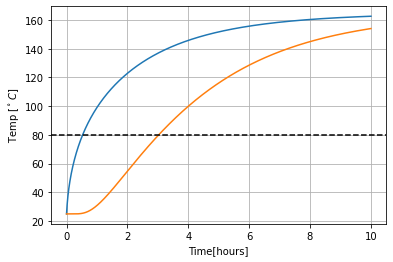

In [79]:
plt.plot(t, avg_temp, label='average')
plt.plot(t, min_temp, label='average')
plt.axhline(80, color='k', ls='--')
plt.xlabel('Time[hours]')
plt.ylabel('Temp [$^\circ C$]')
plt.grid()